In [1]:
import time
import json

import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.__version__)

BATCH_SIZE = 8

## transformations
transform = transforms.Compose([transforms.ToTensor()])

1.13.0


In [3]:
DATA_PATH = "/app/assets/catsdogs/PetImages"

In [4]:
NORMALIZE_COEF = 0.5

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[NORMALIZE_COEF, NORMALIZE_COEF, NORMALIZE_COEF],
                         std=[NORMALIZE_COEF, NORMALIZE_COEF, NORMALIZE_COEF] )
])

In [6]:
data = torchvision.datasets.ImageFolder(root=DATA_PATH, transform=transform)

In [7]:
train_data, test_data, valid_data = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator=torch.Generator().manual_seed(42))

In [8]:
len(train_data), len(test_data), len(valid_data)

(20000, 2500, 2500)

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=BATCH_SIZE,
                                           num_workers=1,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=BATCH_SIZE,
                                          num_workers=1,
                                          shuffle=False)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data,
                                          batch_size=BATCH_SIZE,
                                          num_workers=1,
                                          shuffle=False)

In [10]:
classes = {
    0: 'cat',
    1: 'dog'
}

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [12]:
def imshow(img):
    npimg = (img.numpy() * NORMALIZE_COEF ) + NORMALIZE_COEF
    plt.imshow(np.transpose(npimg, (1, 2, 0)), vmin=0, vmax=255, interpolation='nearest')

In [13]:
def get_labels(labels):
    print([classes[i.item()] for i in labels])

In [14]:
## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

In [15]:
plt.figure(figsize=(20,20))

<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

['cat', 'dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog']


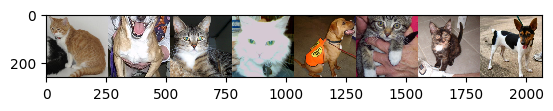

In [16]:
imshow(torchvision.utils.make_grid(images))
get_labels(labels)

In [17]:
class ImageNet(nn.Sequential):
  def __init__(self):
    super().__init__()
    # convolution layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

    # dense layers
    self.fc1 = nn.Linear(in_features=128*31*31, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=60)
    self.out = nn.Linear(in_features=60, out_features=2)
    
  def forward(self, input):
    # print(f'Input before {input.shape}')

    # conv 1
    input = self.conv1(input)
    input = F.relu(input)
    input = F.max_pool2d(input, kernel_size=2, stride=2)
    input = F.dropout(input, 0.2)
    # print(f'After 1: {input.shape}')

    # conv 2
    input = self.conv2(input)
    input = F.relu(input)
    input = F.max_pool2d(input, kernel_size=2, stride=2)
    input = F.dropout(input, 0.2)
    # print(f'After 2: {input.shape}')

    # conv3
    input = self.conv3(input)
    input = F.relu(input)
    input = F.max_pool2d(input, kernel_size=2, stride=2)
    input = F.dropout(input, 0.2)
    # print(f'After 3: {input.shape}')

    # flatten
    input = input.flatten(start_dim = 1)
    # print(f'After flatten: {input.shape}')

    # fc1
    input = self.fc1(input)
    input = F.relu(input)
    input = F.dropout(input, 0.2)

    # fc2
    input = self.fc2(input)
    input = F.relu(input)

    # output
    out = self.out(input)

    return out

In [18]:
## test the model with 1 batch
model = ImageNet()
print("batch size:", images.shape)
out = model(images)
print(out.shape)
print(out[0])

batch size: torch.Size([8, 3, 256, 256])
torch.Size([8, 2])
tensor([-0.0139, -0.0211], grad_fn=<SelectBackward0>)


In [19]:
! pip install torch-lr-finder

In [20]:
# Setup a loss function and a function to compute accuracy of the model
learning_rate = 0.01

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ImageNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()

## compute accuracy
def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

 73%|██████████████████████████████████████████████████████████████████████████████▊                             | 73/100 [00:38<00:14,  1.90it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.36E-02


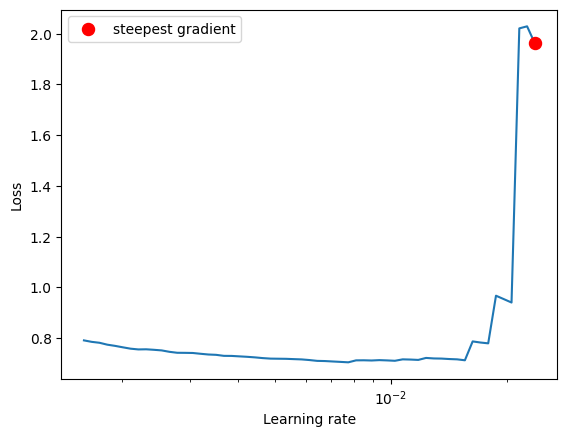

In [21]:
# find best lr
from torch_lr_finder import LRFinder

optimizer2 = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
lr_finder = LRFinder(model, optimizer2, criterion, device=device)
lr_finder.range_test(train_loader, start_lr=1.0E-03, end_lr=0.1, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset()

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=2.60E-02)

num_epochs = 10

# Commented out IPython magic to ensure Python compatibility.
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    model = model.train()

    ## training step
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(logits, labels, BATCH_SIZE)
    
    model.eval()
    print(f'Epoch: {epoch} | Loss: {train_running_loss / i} | Train Accuracy: {train_acc/i}')


KeyboardInterrupt: 

In [ ]:
test_acc = 0.0
for i, (images, labels) in enumerate(test_loader, 0):
    with torch.no_grad:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

In [ ]:
"""### Передбачення для рандомного зображення одягу"""
valid_data = iter(valid_loader)
imgs_test, lbls_test = next(valid_data)

imshow(torchvision.utils.make_grid(imgs[:10]))

In [ ]:
# get random image
from random import randint

idx = randint(0, len(img))

idx

img_to_pred_orig = imgs[idx]

img_to_pred = img_to_pred_orig.repeat(3, 1, 1)

imshow(img_to_pred)

### Label
expected = lbls[idx]
print(expected)
print(classes[expected.item()])

img_to_tensor = img_to_pred_orig.unsqueeze(0)
img_to_tensor = img_to_tensor.to(device)

pred = model(img_to_tensor)
_, result = torch.max(pred, 1)

print(f'Expected {result}. Predicted is {expected}')
print(f'Expected {classes[result.item()]}. Predicted is {classes[expected.item()]}')